In [158]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
import json as json

/Users/mathiasraa/opt/anaconda3/envs/tdt4259/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
with open('helligdager2022.json') as data_file:    
    holidays_2022 = json.load(data_file)  
with open('helligdager2023.json') as data_file:    
    holidays_2023 = json.load(data_file)  

holidays_2022 = pd.json_normalize(holidays_2022, 'data')
holidays_2023 = pd.json_normalize(holidays_2023, 'data')
holidays_2023["date"] = pd.to_datetime(holidays_2023["date"])
holidays_2022["date"] = pd.to_datetime(holidays_2022["date"])
holidays_2022


,date,description
0,2022-01-01,Første nyttårsdag
1,2022-05-01,Offentlig høytidsdag
2,2022-05-17,Grunnlovsdag
3,2022-12-25,Første juledag
4,2022-12-26,Andre juledag
5,2022-04-10,Palmesøndag
6,2022-04-14,Skjærtorsdag
7,2022-04-15,Langfredag
8,2022-04-17,Første påskedag
9,2022-04-18,Andre påskedag


In [91]:
df = pd.read_csv("consumption_temp.csv")
df

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8
...,...,...,...,...
49489,2023-04-02 21:00:00,helsingfors,6.333000,-1.1
49490,2023-04-02 21:00:00,oslo,12.134655,-1.1
49491,2023-04-02 21:00:00,stavanger,5.622820,0.5
49492,2023-04-02 21:00:00,tromsø,2.018333,-2.5


In [155]:
data = df[df["location"] == "oslo"].copy()
data["time"] = pd.to_datetime(data["time"])
data = data.set_index("time")
data = data.asfreq("1h")
data = data.sort_index()

data["is_holiday"] = np.logical_or(
    np.isin(
        pd.to_datetime(data.index).date, pd.to_datetime(holidays_2022["date"]).dt.date
    ),
    np.isin(
        pd.to_datetime(data.index).date, pd.to_datetime(holidays_2023["date"]).dt.date
    ),
)
data = data.rename(columns={"consumption": "y"})
data.head(10)


,location,y,temperature,is_holiday
time,,,,
2022-04-07 21:00:00,oslo,4.092830,1.0,False
2022-04-07 22:00:00,oslo,3.818095,0.4,False
2022-04-07 23:00:00,oslo,3.660981,0.3,False
2022-04-08 00:00:00,oslo,3.584066,0.2,False
2022-04-08 01:00:00,oslo,3.549536,0.4,False
2022-04-08 02:00:00,oslo,3.552738,0.0,False
2022-04-08 03:00:00,oslo,3.638570,-0.4,False
2022-04-08 04:00:00,oslo,3.929940,-0.5,False
2022-04-08 05:00:00,oslo,4.268502,-0.4,False


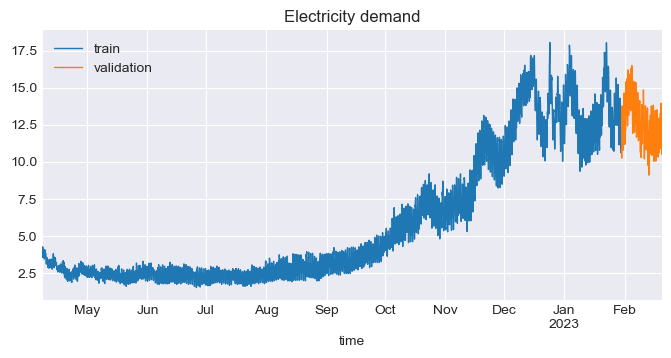

In [164]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=0,
    max_train_size=float("inf"),
    test_size=500,
)

X = data.copy().drop(columns=["y"])
y = data.copy()["y"]

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

fig, ax = plt.subplots(figsize=(8, 3.5))
data.iloc[train_0].y.plot(ax=ax, label='train', linewidth=1)
data.iloc[test_0].y.plot(ax=ax, label='validation', linewidth=1)
ax.set_title('Electricity demand')
ax.legend()

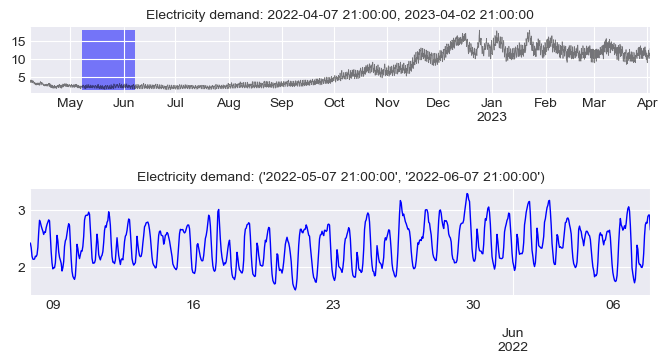

In [56]:
# Zooming time series chart
# ==============================================================================
zoom = ('2022-05-07 21:00:00','2022-06-07 21:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
data.y.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.y)
max_y = max(data.y)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].y.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=10)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

Text(0.5, 0.98, '')

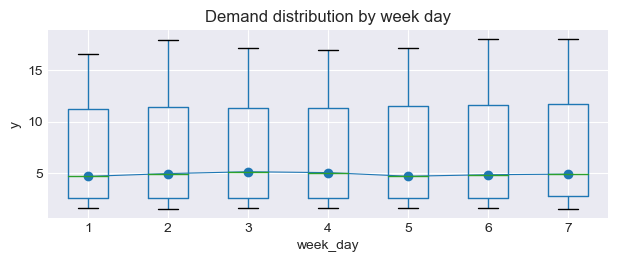

In [59]:
fig, ax = plt.subplots(figsize=(7, 2.5))
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='y', by='week_day', ax=ax)
data.groupby('week_day')['y'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('y')
ax.set_title('Demand distribution by week day')
fig.suptitle('')

Text(0.5, 0.98, '')

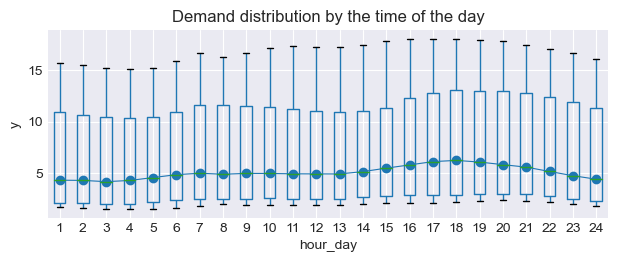

In [122]:
# Boxplot for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data['hour_day'] = data.index.hour + 1
data.boxplot(column='y', by='hour_day', ax=ax)
data.groupby('hour_day')['y'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('y')
ax.set_title('Demand distribution by the time of the day')
fig.suptitle('')

Text(0, 0.5, 'Holiday')

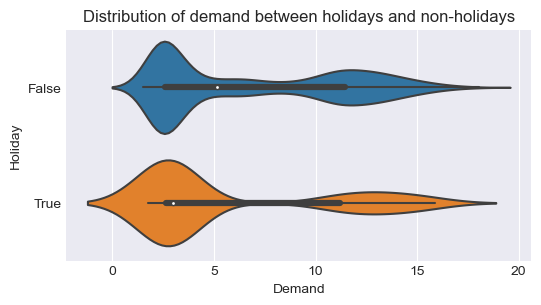

In [157]:
# Violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'y',
    y       = 'is_holiday',
    data    = data.assign(is_holiday = data.is_holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribution of demand between holidays and non-holidays')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday')

In [166]:
data.iloc[train_0].y

time
2022-04-07 21:00:00     4.092830
2022-04-07 22:00:00     3.818095
2022-04-07 23:00:00     3.660981
2022-04-08 00:00:00     3.584066
2022-04-08 01:00:00     3.549536
                         ...    
2023-01-30 05:00:00    11.541245
2023-01-30 06:00:00    12.470842
2023-01-30 07:00:00    12.010561
2023-01-30 08:00:00    11.449527
2023-01-30 09:00:00    11.073542
Freq: H, Name: y, Length: 7141, dtype: float64

In [194]:
from sklearn.preprocessing import MinMaxScaler


forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 24,
                 transformer_y = MinMaxScaler()
             )

forecaster.fit(y=data.iloc[train_0].y)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: MinMaxScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-04-07 21:00:00'), Timestamp('2023-01-30 09:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-09-25 14:31:36 
Last fit date: 2023-09-25 14:31:36 
Skforecast version: 0.10.0 
Python version: 3.10.13 
Forecaster id: None 

In [195]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

exog = [col for col in data.columns if col.startswith(('is_holiday', 'temperature'))]
forecaster.fit(y=data.iloc[train_0].y, exog=data.iloc[train_0][exog])

# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          exog                  = data[exog],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.iloc[train_0])+12,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

# Backtest error
# ==============================================================================
error = mean_absolute_error(
            y_true = data.loc[predictions.index, 'Demand'],
            y_pred = predictions
        )

print("")
print(f"Backtest error: {error}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 7141
Number of observations used for backtesting: 1500
    Number of folds: 63
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 12 observations.

Fold: 0
    Training:   2022-04-07 21:00:00 -- 2023-01-30 09:00:00  (n=7141)
    Validation: 2023-01-30 10:00:00 -- 2023-01-31 09:00:00  (n=24)
Fold: 1
    Training:   2022-04-07 21:00:00 -- 2023-01-30 09:00:00  (n=7141)
    Validation: 2023-01-31 10:00:00 -- 2023-02-01 09:00:00  (n=24)
Fold: 2
    Training:   2022-04-07 21:00:00 -- 2023-01-30 09:00:00  (n=7141)
    Validation: 2023-02-01 10:00:00 -- 2023-02-02 09:00:00  (n=24)
Fold: 3
    Training:   2022-04-07 21:00:00 -- 2023-01-30 09:00:00  (n=7141)
    Validation: 2023-02-02 10:00:00 -- 2023-02-03 09:00:00  (n=24)
Fold: 4
    Training:   2022-04-07 21:00:00 -- 2023-01-30 09:00

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:00<00:00, 325.91it/s]


Backtest error: 0.6323855198779441


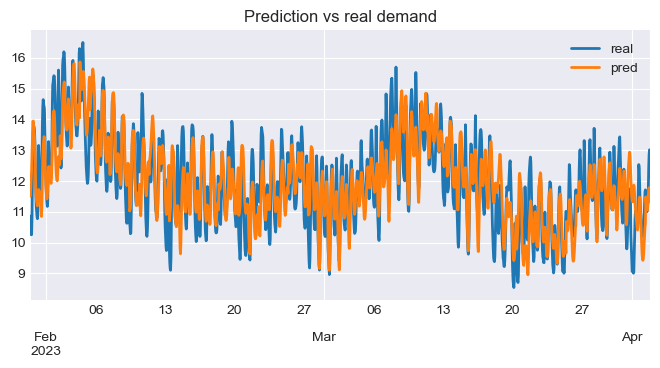

In [199]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'y'].plot(ax=ax, linewidth=2, label='real')
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend();
print(f'Backtest error: {metric}')


In [203]:
# Backtest with gap
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['y'],
                          exog                  = data['temperature'],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data.iloc[train_0].y),
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True  
                      )

print(metric)

100%|██████████| 63/63 [00:00<00:00, 276.62it/s]

0.6323855198779441


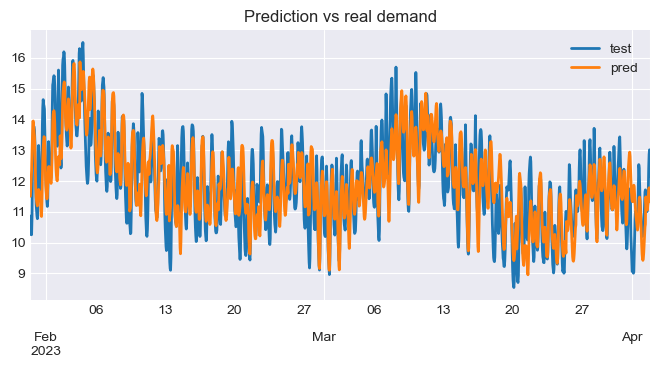

In [204]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
data.loc[predictions.index, 'y'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='prediction', ax=ax)
ax.set_title('Prediction vs real demand')
ax.legend()